In [5]:
import pickle
from collections import Counter

# 1. 读取 pkl 数据
path = r"/playpen-shared/kechengli/workspace/dataset/d/data.pkl"
with open(path, "rb") as f:
    data = pickle.load(f)

data


[array([[  0.        , 175.53191489,  31.99320498, ...,  90.31490015,
         114.57534247,  47.91200597],
        [  0.        , 164.89361702,  31.28539071, ...,  93.01075269,
         120.74657534,  46.23415362],
        [  0.        , 154.78723404,  31.56851642, ...,  90.3187404 ,
         126.23287671,  47.53914989],
        ...,
        [ 84.67741935, 140.42553191,  61.86296716, ..., 155.2688172 ,
         232.90753425, 107.94183445],
        [ 61.05990783, 127.65957447,  41.7610419 , ..., 146.81643625,
         144.73972603,  79.97762864],
        [ 47.81105991, 114.36170213,  40.20385051, ..., 125.67588326,
         143.02739726,  66.92766592]]),
 array([[0., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        [0., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]])]

In [6]:
import os

# 目标路径
data_dir = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/physio"

# 递归统计所有 txt 文件
txt_files = []
for root, _, files in os.walk(data_dir):
    for f in files:
        if f.endswith(".txt"):
            txt_files.append(os.path.join(root, f))

# 输出结果
print(f"📁 physio在目录 {data_dir} 中共找到 {len(txt_files)} 个 .txt 文件。")

# 如果文件太多，只展示前 10 个示例


📁 physio在目录 /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/physio 中共找到 4000 个 .txt 文件。


In [7]:
import pickle

import os
import re
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset

# 35 attributes which contains enough non-values
attributes = ['DiasABP', 'HR', 'Na', 'Lactate', 'NIDiasABP', 'PaO2', 'WBC', 'pH', 'Albumin', 'ALT', 'Glucose', 'SaO2',
              'Temp', 'AST', 'Bilirubin', 'HCO3', 'BUN', 'RespRate', 'Mg', 'HCT', 'SysABP', 'FiO2', 'K', 'GCS',
              'Cholesterol', 'NISysABP', 'TroponinT', 'MAP', 'TroponinI', 'PaCO2', 'Platelets', 'Urine', 'NIMAP',
              'Creatinine', 'ALP']


def extract_hour(x):
    h, _ = map(int, x.split(":"))
    return h


def parse_data(x):
    # extract the last value for each attribute
    x = x.set_index("Parameter").to_dict()["Value"]

    values = []

    for attr in attributes:
        if x.__contains__(attr):
            values.append(x[attr])
        else:
            values.append(np.nan)
    return values


def parse_id(id_, missing_ratio=0.1):
    data = pd.read_csv("./data/physio/set-a/{}.txt".format(id_))
    # set hour
    data["Time"] = data["Time"].apply(lambda x: extract_hour(x))

    # create data for 48 hours x 35 attributes
    observed_values = []
    for h in range(48):
        observed_values.append(parse_data(data[data["Time"] == h]))
    observed_values = np.array(observed_values)
    observed_masks = ~np.isnan(observed_values)

    # randomly set some percentage as ground-truth
    masks = observed_masks.reshape(-1).copy()
    obs_indices = np.where(masks)[0].tolist()
    miss_indices = np.random.choice(
        obs_indices, (int)(len(obs_indices) * missing_ratio), replace=False
    )
    masks[miss_indices] = False
    gt_masks = masks.reshape(observed_masks.shape)

    observed_values = np.nan_to_num(observed_values)
    observed_masks = observed_masks.astype("float32")
    gt_masks = gt_masks.astype("float32")

    return observed_values, observed_masks, gt_masks


def get_idlist():
    patient_id = []
    for filename in os.listdir("./data/physio/set-a"):
        match = re.search("\d{6}", filename)
        if match:
            patient_id.append(match.group())
    patient_id = np.sort(patient_id)
    return patient_id


class Physio_Dataset(Dataset):
    def __init__(self, eval_length=48, use_index_list=None, missing_ratio=0.0, seed=0):
        self.eval_length = eval_length
        np.random.seed(seed)  # seed for ground truth choice

        self.observed_values = []
        self.observed_masks = []
        self.gt_masks = []
        path = (
            "./data/physio_missing" + str(missing_ratio) + "_seed" + str(seed) + ".pk"
        )

        if os.path.isfile(path) == False:  # if datasetfile is none, create
            idlist = get_idlist()
            for id_ in idlist:
                try:
                    observed_values, observed_masks, gt_masks = parse_id(
                        id_, missing_ratio
                    )
                    self.observed_values.append(observed_values)
                    self.observed_masks.append(observed_masks)
                    self.gt_masks.append(gt_masks)
                except Exception as e:
                    print(id_, e)
                    continue
            self.observed_values = np.array(self.observed_values)
            self.observed_masks = np.array(self.observed_masks)
            self.gt_masks = np.array(self.gt_masks)

            # calc mean and std and normalize values
            # (it is the same normalization as Cao et al. (2018) (https://github.com/caow13/BRITS))
            tmp_values = self.observed_values.reshape(-1, 35)
            tmp_masks = self.observed_masks.reshape(-1, 35)
            mean = np.zeros(35)
            std = np.zeros(35)
            for k in range(35):
                c_data = tmp_values[:, k][tmp_masks[:, k] == 1]
                mean[k] = c_data.mean()
                std[k] = c_data.std()
            self.observed_values = (
                (self.observed_values - mean) / std * self.observed_masks
            )

            with open(path, "wb") as f:
                pickle.dump(
                    [self.observed_values, self.observed_masks, self.gt_masks], f
                )
        else:  # load datasetfile
            with open(path, "rb") as f:
                self.observed_values, self.observed_masks, self.gt_masks = pickle.load(
                    f
                )
        if use_index_list is None:
            self.use_index_list = np.arange(len(self.observed_values))
        else:
            self.use_index_list = use_index_list

    def __getitem__(self, org_index):
        index = self.use_index_list[org_index]
        s = {
            "observed_data": self.observed_values[index],
            "observed_mask": self.observed_masks[index],
            "gt_mask": self.gt_masks[index],
            "timepoints": np.arange(self.eval_length),
        }
        return s

    def __len__(self):
        return len(self.use_index_list)


def get_dataloader(seed=1, nfold=None, batch_size=16, missing_ratio=0.1):

    # only to obtain total length of dataset
    dataset = Physio_Dataset(missing_ratio=missing_ratio, seed=seed)
    indlist = np.arange(len(dataset))

    np.random.seed(seed)
    np.random.shuffle(indlist)

    # 5-fold test
    start = (int)(nfold * 0.2 * len(dataset))
    end = (int)((nfold + 1) * 0.2 * len(dataset))
    test_index = indlist[start:end]
    remain_index = np.delete(indlist, np.arange(start, end))

    np.random.seed(seed)
    np.random.shuffle(remain_index)
    num_train = (int)(len(dataset) * 0.7)
    train_index = remain_index[:num_train]
    valid_index = remain_index[num_train:]

    dataset = Physio_Dataset(
        use_index_list=train_index, missing_ratio=missing_ratio, seed=seed
    )
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=1)
    valid_dataset = Physio_Dataset(
        use_index_list=valid_index, missing_ratio=missing_ratio, seed=seed
    )
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=0)
    test_dataset = Physio_Dataset(
        use_index_list=test_index, missing_ratio=missing_ratio, seed=seed
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=0)
    return train_loader, valid_loader, test_loader


In [8]:
train_loader, valid_loader, test_loader = get_dataloader(
    seed=10,
    nfold=4,
    batch_size=16,
    missing_ratio=0.1,
)


In [32]:
for batch in train_loader:
    print(batch["observed_data"].shape)
    for k, v in batch.items():
        print(f"{k:15s}  shape={v.shape}  dtype={v.dtype}")
    break


torch.Size([16, 48, 35])
observed_data    shape=torch.Size([16, 48, 35])  dtype=torch.float64
observed_mask    shape=torch.Size([16, 48, 35])  dtype=torch.float32
gt_mask          shape=torch.Size([16, 48, 35])  dtype=torch.float32
timepoints       shape=torch.Size([16, 48])  dtype=torch.int64


dict_keys(['observed_data', 'observed_mask', 'gt_mask', 'timepoints'])


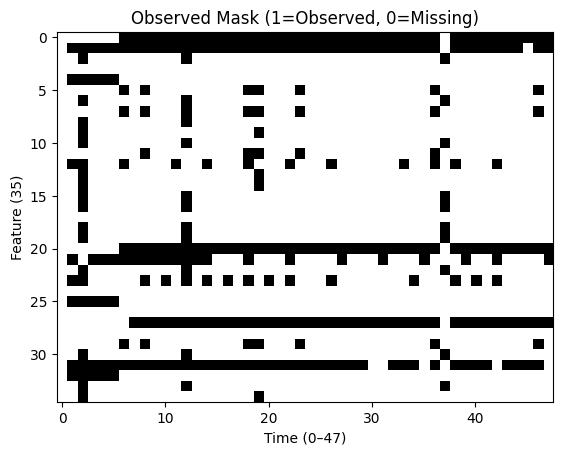

In [21]:
sample = train_loader.dataset[100]
print(sample.keys())

import matplotlib.pyplot as plt

plt.imshow(sample["observed_mask"].T, aspect='auto', cmap='gray_r')
plt.title("Observed Mask (1=Observed, 0=Missing)")
plt.xlabel("Time (0–47)")
plt.ylabel("Feature (35)")
plt.show()

In [1]:
# %%
import pickle
import numpy as np
import torch
import os

# %%
# === Step 1: 指定文件路径 ===
file_path = r"/playpen-shared/kechengli/workspace/dataset/mimiciv_after_diff/val_ihm-48-cxr-notes-ecg-missingInd_stays.pkl"

assert os.path.exists(file_path), f"❌ 文件不存在：{file_path}"
print(f"✅ 正在加载：{file_path}")

# %%
# === Step 2: 加载 pkl 文件 ===
with open(file_path, "rb") as f:
    data = pickle.load(f)

print(f"✅ 加载成功：共 {len(data)} 条样本，类型：{type(data)}")

# %%
# === Step 3: 查看前 N 条样本 ===
N = 4  # 可以改成 10
for i, sample in enumerate(data[:N]):
    print(f"\n================= 🩺 样本 {i+1}/{N} =================")
    if not isinstance(sample, dict):
        print(f"⚠️ 第 {i+1} 个不是字典，而是 {type(sample)}")
        continue

    for k, v in sample.items():
        # 尝试打印出每个字段的类型和形状
        if isinstance(v, (list, np.ndarray, torch.Tensor)):
            try:
                shape = np.array(v).shape
            except Exception:
                shape = "未知"
            print(f"{k:25s} | 类型: {type(v).__name__:10s} | 形状: {shape} | 示例: {str(v)[:120]}")
        elif isinstance(v, dict):
            print(f"{k:25s} | 类型: dict (len={len(v)})")
        else:
            print(f"{k:25s} | 类型: {type(v).__name__:10s} | 值: {v}")


✅ 正在加载：/playpen-shared/kechengli/workspace/dataset/mimiciv_after_diff/val_ihm-48-cxr-notes-ecg-missingInd_stays.pkl
✅ 加载成功：共 5270 条样本，类型：<class 'list'>

================= 🩺 样本 1/4 =================
name                      | 类型: int64      | 值: 14120635
hadm_id                   | 类型: int64      | 值: 26800029
stay_id                   | 类型: int        | 值: 36850695
ts_tt                     | 类型: ndarray    | 形状: (110,) | 示例: [0.26666666666666666 0.2833333333333333 0.43333333333333335 0.6 0.65
 1.2666666666666666 1.2833333333333334 2.2666666666
irg_ts                    | 类型: ndarray    | 形状: (110, 30) | 示例: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 
irg_ts_mask               | 类型: ndarray    | 形状: (110, 30) | 示例: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
reg_ts                    | 类型: ndarray    | 形状: (48, 30) | 示例: [[-0.05523084

In [47]:
import os
import pickle
import numpy as np

def hours_to_HHMM(hours: float) -> str:
    total_minutes = int(round(hours * 60))
    hh = total_minutes // 60
    mm = total_minutes % 60
    return f"{hh:02d}:{mm:02d}"

def is_valid_number(x) -> bool:
    try:
        return np.isfinite(x)
    except Exception:
        return False

def build_default_param_names(K: int):
    base = [
        "HR","NISysABP","NIDiasABP","NIMAP","RespRate","Temp","Urine",
        "BUN","Creatinine","Glucose","HCO3","HCT","Platelets","Mg","K","Na","WBC",
        "GCS","FiO2","SpO2","PaO2","PaCO2","pH","Lactate","Bilirubin","ALT","AST",
        "Albumin","HGB","RBC"
    ]
    if K <= len(base):
        return base[:K]
    return base + [f"Param_{i:02d}" for i in range(len(base)+1, K+1)]

def write_one_sample_txt(sample: dict, out_dir: str, param_names=None):
    """
    必备字段：
        hadm_id, ts_tt(T,), irg_ts(T,K), irg_ts_mask(T,K) (1=观测, 0=缺失)
    规则：
        - 只写观测到的条目：mask==1 且值为有限数；否则“跳过该行”（不写 -1）
        - 参数名与列索引保持一致，不会错位
    """
    stay_id = int(sample.get("stay_id"))
    ts_tt  = np.asarray(sample["ts_tt"])                 # (T,)
    X      = np.asarray(sample["irg_ts"])                # (T,K)
    M      = np.asarray(sample["irg_ts_mask"]).astype(int)  # (T,K)

    assert ts_tt.ndim == 1
    assert X.ndim == 2 and M.ndim == 2 and X.shape == M.shape
    T, K = X.shape

    # 参数名就位（严格按列索引映射）
    if param_names is None:
        param_names = build_default_param_names(K)
    elif len(param_names) != K:
        # 保证一一对应（不匹配时按列裁剪/补齐，不会改变索引语义）
        if len(param_names) > K:
            param_names = param_names[:K]
        else:
            param_names = param_names + [f"Param_{i:02d}" for i in range(len(param_names)+1, K+1)]

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{stay_id}.txt")

    with open(out_path, "w", encoding="utf-8") as f:
        f.write("Time,Parameter,Value\n")
        f.write(f"00:00,RecordID,{stay_id}\n")

        for t in range(T):
            hhmm = hours_to_HHMM(float(ts_tt[t]))
            # 仅写入“观测且有效”的条目；缺失的（mask==0）直接不写
            for k in range(K):
                if M[t, k] == 1 and is_valid_number(X[t, k]):
                    # 注意：真实值允许为负（如标准化后的负数），不会被删除
                    f.write(f"{hhmm},{param_names[k]},{X[t, k]}\n")

    return out_path

def convert_pkl_to_csdi_txt(pkl_path: str, out_dir: str, sample_limit: int=None, param_names=None):
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    n = len(data) if sample_limit is None else min(len(data), sample_limit)
    out_files = []
    for i in range(n):
        s = data[i]
        if all(k in s for k in ["ts_tt", "irg_ts", "irg_ts_mask"]):
            out_files.append(write_one_sample_txt(s, out_dir, param_names=param_names))
    return out_files

In [ ]:
# === 使用示例 ===
PKL_PATH = r"/playpen-shared/kechengli/workspace/dataset/mimiciv_pkl/train_ihm-48-cxr-notes-ecg-missingInd_stays.pkl"
OUT_DIR = r"/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data_train"

# 可选：自定义 30 个参数名（顺序需与你的 irg_ts 列维度一致）
custom_param_names = [
    "HR","NISysABP","NIDiasABP","NIMAP","RespRate","Temp","Urine",
    "BUN","Creatinine","Glucose","HCO3","HCT","Platelets","Mg","K","Na","WBC",
    "GCS","FiO2","SpO2","PaO2","PaCO2","pH","Lactate","Bilirubin","ALT","AST",
    "Albumin","HGB","RBC"
]  # 若与你的 30 维不一致，会自动补/裁切

files = convert_pkl_to_csdi_txt(
    PKL_PATH,
    OUT_DIR,
    sample_limit=None,            # 改为 10 可先导出 10 个试试
    param_names=custom_param_names
)
print(f"导出完成，共 {len(files)} 个 txt。示例：{files[:3]}")

导出完成，共 24590 个 txt。示例：['/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data/38544470.txt', '/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data/39784741.txt', '/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data/36886741.txt']


In [50]:
import os
from collections import Counter

OUT_DIR = r"/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data_train"

def count_filename_digit_lengths(directory):
    files = [f for f in os.listdir(directory) if f.endswith(".txt")]
    lengths = []

    for f in files:
        # 去掉扩展名
        name = os.path.splitext(f)[0]
        # 如果全是数字，则统计长度
        if name.isdigit():
            lengths.append(len(name))
        else:
            print(f"⚠️ 非纯数字文件名跳过: {f}")

    counter = Counter(lengths)
    total = len(lengths)
    print(f"📂 共找到 {total} 个纯数字 txt 文件")
    print("位数分布：")
    for digits, count in sorted(counter.items()):
        print(f"  {digits} 位数字: {count} 个文件")

    return counter

if __name__ == "__main__":
    count_filename_digit_lengths(OUT_DIR)


📂 共找到 24590 个纯数字 txt 文件
位数分布：
  8 位数字: 24590 个文件


In [10]:
import pickle
from collections import Counter

def check_duplicate_hadm_ids(pkl_path):
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    # 从每个样本中提取 hadm_id（如果不存在，用 None）
    hadm_ids = [sample.get("stay_id", None) for sample in data]

    # 统计重复项
    counter = Counter(hadm_ids)
    duplicates = {hid: cnt for hid, cnt in counter.items() if cnt > 1}

    print(f"✅ 总样本数: {len(hadm_ids)}")
    print(f"🆔 不同 stay_id 数: {len(counter)}")

    if duplicates:
        print(f"\n⚠️ 发现 {len(duplicates)} 个重复的 stay_id")
        for hid, cnt in sorted(duplicates.items(), key=lambda x: -x[1]):
            print(f"stay_id {hid}: 出现 {cnt} 次")
    else:
        print("\n✅ 没有发现重复的 stay_id")

    return duplicates

PKL_PATH = r"/playpen-shared/kechengli/workspace/dataset/mimiciv_pkl/train_ihm-48-cxr-notes-ecg-missingInd_stays.pkl"
duplicates = check_duplicate_hadm_ids(PKL_PATH)

✅ 总样本数: 24590
🆔 不同 stay_id 数: 24590

✅ 没有发现重复的 stay_id


In [1]:
import pickle
import numpy as np
import torch
import pandas as pd

def to_numpy(x):
    """兼容 numpy / torch 张量"""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, np.ndarray):
        return x
    else:
        return np.array(x)
    
def show_full_sample(pk_path, sample_idx=0, export_csv=True):
    with open(pk_path, "rb") as f:
        data = pickle.load(f)

    (all_generated_samples,
     all_target,
     all_evalpoint,
     all_observed_point,
     all_observed_time,
     scaler,
     mean_scaler) = data

    gen = to_numpy(all_generated_samples)
    obs_mask = to_numpy(all_observed_point)
    times = to_numpy(all_observed_time)

    N, nsample, L, K = gen.shape
    print(f"✅ 文件加载成功: {pk_path}")
    print(f"共有 {N} 个样本，每个样本 {L} 时间步，{K} 特征，生成 {nsample} 个采样。")

    i = sample_idx
    g = gen[i, 0]      # 插补结果 (L,K)
    m = obs_mask[i]    # 原始掩码 (L,K)
    t = times[i]

    # 插补掩码：1 = 模型生成的值
    imp_mask = 1 - m
    imp_ratio = imp_mask.mean()

    print(f"\n🩺 样本 {i}: 插补矩阵形状 = {g.shape}")
    print(f"观测比例: {m.mean():.3f} | 插补比例: {imp_ratio:.3f}")
    print(f"时间示例: {np.round(t[:10], 3)} ...")

    # 构造 DataFrame
    df = pd.DataFrame(g, columns=[f"feature_{j}" for j in range(K)])
    df.insert(0, "time", t)

    # 新增：加入 mask 列（每行 1 表示这一时间步存在插补值）
    df_mask = pd.DataFrame(imp_mask, columns=[f"mask_{j}" for j in range(K)])
    df_mask.insert(0, "time", t)

    print("\n完整插补矩阵 (前几行示例):")
    print(df.head(10))

    if export_csv:
        df.to_csv(f"sample_{i}_imputed.csv", index=False)
        df_mask.to_csv(f"sample_{i}_mask.csv", index=False)
        print(f"\n📄 已导出完整插补矩阵到: sample_{i}_imputed.csv")
        print(f"📄 已导出对应掩码矩阵到: sample_{i}_mask.csv")

    return df, df_mask



pk_path = r"/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_test10_20251119_004908/generated_outputs_nsample30.pk"  # 修改为你的路径
show_full_sample(pk_path, sample_idx=1)


ValueError: too many values to unpack (expected 7)

In [5]:
import pickle
import numpy as np
from dataset_ihm import get_idlist

# 载入模型输出
pk_path = r"./save/ihm_fold0_20251110_044310/generated_outputs_nsample1.pk"
with open(pk_path, "rb") as f:
    data = pickle.load(f)

all_generated_samples = data[0]
print(f"模型输出样本数: {len(all_generated_samples)}")

# 载入原始 txt ID 列表
ids = get_idlist()
print(f"TXT 文件数: {len(ids)}")

# 检查是否完全一致
if len(ids) == len(all_generated_samples):
    print("✅ 样本数量一致。每个模型输出样本可与 idlist 对齐。")
    print("示例映射：")
    for i in range(5):
        print(f"  模型样本 {i} ↔️ TXT 文件 {ids[i]}.txt")
else:
    print("⚠️ 数量不一致，请检查数据目录或过滤逻辑。")


模型输出样本数: 4918
TXT 文件数: 24590
⚠️ 数量不一致，请检查数据目录或过滤逻辑。


In [ ]:
import pandas as pd
import numpy as np

# 你的文件路径
path = "/playpen-shared/kechengli/workspace/dataset/d/22987622_irg_ts.csv"

# 读取数据
df = pd.read_csv(path)

# 去掉时间列
features = [c for c in df.columns if c.lower() not in ["time", "timett", "timestamp"]]
data = df[features]

# 计算每个变量的范围和统计信息
stats = []
for col in features:
    vals = data[col].values
    vals = vals[np.isfinite(vals)]  # 去除NaN
    if len(vals) == 0:
        continue
    mean = vals.mean()
    std = vals.std()
    vmin, vmax = vals.min(), vals.max()
    stats.append((col, mean, std, vmin, vmax))

# 打印结果
print(f"✅ 检查文件: {path}")
print(f"共 {len(features)} 个变量（排除时间列）\n")

for col, mean, std, vmin, vmax in stats:
    flag = ""
    if (vmin >= -1.05) and (vmax <= 1.05):
        flag = "✅ 近似 [-1,1]"
    elif abs(mean) < 1 and 0.8 < std < 1.2:
        flag = "⚠️ 近似标准正态"
    else:
        flag = "❌ 未归一化"
    print(f"{col:10s}  mean={mean:8.3f}  std={std:8.3f}  "
          f"min={vmin:8.3f}  max={vmax:8.3f}  {flag}")


In [2]:
import pickle, numpy as np, torch

def to_np(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)

pk = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_test10_20251119_004908/generated_outputs_nsample30.pk"
with open(pk, "rb") as f:
    gen, target, evalmask, obsmask, times, scaler, mean = pickle.load(f)

gen, target, obsmask = map(to_np, (gen, target, obsmask))

print(f"scaler={scaler}, mean_scaler={mean}")
print(f"观测点值范围: {target[obsmask==1].min():.3f} ~ {target[obsmask==1].max():.3f}")
print(f"插补输出范围: {gen[:,0,:,:][obsmask==0].min():.3f} ~ {gen[:,0,:,:][obsmask==0].max():.3f}")


ValueError: too many values to unpack (expected 7)

In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

SRC_DIR = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data_train"
DST_DIR = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data_train_new"

def clip_values(src_dir=SRC_DIR, dst_dir=DST_DIR):
    os.makedirs(dst_dir, exist_ok=True)
    files = [f for f in os.listdir(src_dir) if f.endswith(".txt")]
    print(f"📁 共找到 {len(files)} 个 .txt 文件，将逐一处理...")

    for fn in tqdm(files, desc="Processing txt files"):
        src_path = os.path.join(src_dir, fn)
        dst_path = os.path.join(dst_dir, fn)
        try:
            df = pd.read_csv(src_path)

            # 若列名异常，跳过
            if "Parameter" not in df.columns or "Value" not in df.columns:
                print(f"⚠️  {fn} 缺列名，跳过")
                continue

            # 对非 RecordID 行裁剪到 [-1, 1]
            mask = df["Parameter"] != "RecordID"
            df.loc[mask, "Value"] = pd.to_numeric(df.loc[mask, "Value"], errors="coerce")
            df.loc[mask, "Value"] = df.loc[mask, "Value"].clip(-1.0, 1.0)

            # 保持原顺序保存
            df.to_csv(dst_path, index=False)

        except Exception as e:
            print(f"❌ 处理 {fn} 出错: {e}")
            continue

    print(f"\n✅ 所有文件已处理完毕，结果保存在: {dst_dir}")

if __name__ == "__main__":
    clip_values()


📁 共找到 24590 个 .txt 文件，将逐一处理...


Processing txt files: 100%|██████████| 24590/24590 [02:53<00:00, 141.58it/s]


✅ 所有文件已处理完毕，结果保存在: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_data_train_new


In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, pickle
import numpy as np
import torch
import pandas as pd
from pprint import pprint

PK_PATH = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/data/ihm_missing_withid0_seed1.pk"   # 👈 按你的真实路径填写
SAMPLE_IDX = 0                               # 👈 想看的样本编号

def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def brief_arr(x, rows=3, cols=6):
    """把 (L,K) 的矩阵裁一小块，方便预览"""
    x = to_np(x)
    L, K = x.shape[:2]
    r = min(rows, L)
    c = min(cols, K)
    return pd.DataFrame(x[:r, :c],
                        index=[f"t{t}" for t in range(r)],
                        columns=[f"f{j}" for j in range(c)])

def main(pk_path=PK_PATH, sample_idx=SAMPLE_IDX):
    if not os.path.isfile(pk_path):
        raise FileNotFoundError(f"找不到文件: {pk_path}")

    with open(pk_path, "rb") as f:
        payload = pickle.load(f)

    print("=== 文件已读取 ===")
    print("容器类型:", type(payload))
    if isinstance(payload, (list, tuple)):
        print("元素个数:", len(payload))
    print("-" * 60)

    # 兼容几种常见结构：
    # 3 元素: [observed_values, observed_masks, gt_masks]
    # 4 元素: [observed_values, observed_masks, gt_masks, patient_ids]
    # 其它: 尝试按键名或推断
    observed_values = observed_masks = gt_masks = patient_ids = None

    if isinstance(payload, (list, tuple)):
        if len(payload) >= 3:
            observed_values, observed_masks, gt_masks = payload[:3]
        if len(payload) >= 4:
            patient_ids = payload[3]
    elif isinstance(payload, dict):
        # 字典就猜常用键
        observed_values = payload.get("observed_values")
        observed_masks  = payload.get("observed_masks")
        gt_masks        = payload.get("gt_masks")
        patient_ids     = payload.get("patient_ids")

    # 转 numpy 便于查看
    ov = to_np(observed_values) if observed_values is not None else None
    om = to_np(observed_masks)  if observed_masks  is not None else None
    gm = to_np(gt_masks)        if gt_masks        is not None else None

    # 打印总体信息
    if ov is not None:
        print(f"observed_values: type={type(observed_values)}, shape={ov.shape}")
    if om is not None:
        print(f"observed_masks : type={type(observed_masks)},  shape={om.shape}")
    if gm is not None:
        print(f"gt_masks       : type={type(gt_masks)},        shape={gm.shape}")
    if patient_ids is not None:
        print(f"patient_ids    : type={type(patient_ids)},     len={len(patient_ids)}")
    print("-" * 60)

    # 选择样本
    N = ov.shape[0] if ov is not None else (
        om.shape[0] if om is not None else (
            gm.shape[0] if gm is not None else 0
        )
    )
    idx = max(0, min(sample_idx, max(0, N-1)))
    print(f"样本示例：index = {idx} / N = {N}")
    print()

    # 逐字段示例
    if ov is not None:
        print("【observed_values】(该样本的小切片, 行=前3个时间步, 列=前6个特征)")
        print(brief_arr(ov[idx]))
        print("数值范围(全序列):",
              float(np.nanmin(ov[idx])), "→", float(np.nanmax(ov[idx])))
        print()

    if om is not None:
        ones = int(om[idx].sum())
        total = int(np.prod(om[idx].shape))
        print("【observed_masks】(1=原始有观测, 0=原始缺失) 该样本统计：")
        print(f"  1 的数量 = {ones} / {total}  (观测占比={ones/total:.3f})")
        print("小切片：")
        print(brief_arr(om[idx]))
        print()

    if gm is not None:
        ones = int(gm[idx].sum())
        total = int(np.prod(gm[idx].shape))
        print("【gt_masks】(1=评测保留可见, 0=评测被抹去成为目标) 该样本统计：")
        print(f"  1 的数量 = {ones} / {total}  (占比={ones/total:.3f})")
        print("小切片：")
        print(brief_arr(gm[idx]))
        print("提示：若构建缓存时 missing_ratio=0.0，gt_masks 很可能全 1。")
        print()

    if patient_ids is not None:
        # 兼容 ndarray / list / tensor
        try:
            if isinstance(patient_ids, torch.Tensor):
                pid = str(int(patient_ids[idx]))
            elif isinstance(patient_ids, (list, tuple, np.ndarray)):
                pid = str(patient_ids[idx])
            else:
                pid = str(patient_ids)
        except Exception:
            pid = str(patient_ids)
        print("【patient_ids】")
        print("  示例：", pid)
        print("  对应原始文件：", f"./data/ihm_data_train/{pid}.txt")
        print()

    # 汇总字典（可在 notebook 里复用）
    summary = {
        "observed_values_shape": None if ov is None else ov.shape,
        "observed_masks_shape":  None if om is None else om.shape,
        "gt_masks_shape":        None if gm is None else gm.shape,
        "num_samples": N,
        "sample_index": idx,
        "patient_id": pid if patient_ids is not None else None,
    }
    print("=== Summary ===")
    pprint(summary)

if __name__ == "__main__":
    main()


=== 文件已读取 ===
容器类型: <class 'list'>
元素个数: 4
------------------------------------------------------------
observed_values: type=<class 'numpy.ndarray'>, shape=(24590, 48, 30)
observed_masks : type=<class 'numpy.ndarray'>,  shape=(24590, 48, 30)
gt_masks       : type=<class 'numpy.ndarray'>,        shape=(24590, 48, 30)
patient_ids    : type=<class 'numpy.ndarray'>,     len=24590
------------------------------------------------------------
样本示例：index = 0 / N = 24590

【observed_values】(该样本的小切片, 行=前3个时间步, 列=前6个特征)
     f0   f1   f2   f3   f4   f5
t0  0.0  0.0  0.0  0.0  0.0  0.0
t1  0.0  0.0  0.0  0.0  0.0  0.0
t2  0.0  0.0  0.0  0.0  0.0  0.0
数值范围(全序列): -1.0 → 0.9375311173707164

【observed_masks】(1=原始有观测, 0=原始缺失) 该样本统计：
  1 的数量 = 348 / 1440  (观测占比=0.242)
小切片：
     f0   f1   f2   f3   f4   f5
t0  0.0  0.0  0.0  0.0  0.0  0.0
t1  0.0  0.0  0.0  0.0  0.0  0.0
t2  0.0  0.0  0.0  0.0  0.0  0.0

【gt_masks】(1=评测保留可见, 0=评测被抹去成为目标) 该样本统计：
  1 的数量 = 348 / 1440  (占比=0.242)
小切片：
     f0   f1   f2   f3

In [3]:
import pickle
import numpy as np
import torch
import pandas as pd
from pprint import pprint

# 你的 pkl 路径
PK_PATH = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_test10_20251119_004908/generated_outputs_nsample30.pk"

# 要查看的样本编号
SAMPLE_IDX = 0


def to_numpy(x):
    """兼容 numpy / torch 张量"""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)


def preview_matrix(x, r=30, c=30
                   ):
    """裁取矩阵前几行列方便预览"""
    x = to_numpy(x)
    L, K = x.shape[:2]
    r = min(r, L)
    c = min(c, K)
    return pd.DataFrame(
        x[:r, :c],
        index=[f"t{i}" for i in range(r)],
        columns=[f"f{j}" for j in range(c)]
    )

def main():
    print(f"📦 正在加载: {PK_PATH}")

    with open(PK_PATH, "rb") as f:
        data = pickle.load(f)

    print("\n=== 文件结构 ===")
    print("类型:", type(data))
    if isinstance(data, (list, tuple)):
        print("元素个数:", len(data))
    print("-" * 60)

    # 按照 evaluate() 的保存顺序解包
    (
        all_generated_samples,   # 0
        all_target,              # 1
        all_evalpoint,           # 2
        all_observed_point,      # 3
        all_observed_time,       # 4
        scaler,                  # 5
        mean_scaler,             # 6
        patient_ids              # 7
    ) = data

    # 转 numpy
    gen = to_numpy(all_generated_samples)
    target = to_numpy(all_target)
    evalmask = to_numpy(all_evalpoint)
    obsmask = to_numpy(all_observed_point)
    times = to_numpy(all_observed_time)

    print("all_generated_samples :", type(all_generated_samples), gen.shape)
    print("all_target            :", type(all_target), target.shape)
    print("all_evalpoint         :", type(all_evalpoint), evalmask.shape)
    print("all_observed_point    :", type(all_observed_point), obsmask.shape)
    print("all_observed_time     :", type(all_observed_time), times.shape)
    print("scaler                :", type(scaler))
    print("mean_scaler           :", type(mean_scaler))
    print("patient_ids (#)       :", len(patient_ids))
    print("-" * 60)

    # ---- 选择一个样本查看 ----
    idx = SAMPLE_IDX
    print(f"\n📌 查看样本 index = {idx}, 对应 patient_id = {patient_ids[idx]}")
    print(f"原始 txt: ./data/ihm_data_train/{patient_ids[idx]}.txt")

    N, nsample, L, K = gen.shape

    print("\n=== 1) 插补生成值示例 (gen) ===")
    print("shape:", gen[idx].shape)
    print("前几行前几列:")
    print(preview_matrix(gen[idx][20]))   # 使用第 0 条采样轨迹

    print("\n=== 2) 目标真值 (target) ===")
    print("shape:", target[idx].shape)
    print(preview_matrix(target[idx]))

    print("\n=== 3) 评测掩码 evalmask (1=评测点) ===")
    print("shape:", evalmask[idx].shape)
    print(preview_matrix(evalmask[idx]))

    print("\n=== 4) 观测掩码 obsmask (1=原始观测点) ===")
    print("shape:", obsmask[idx].shape)
    print(preview_matrix(obsmask[idx]))

    print("\n=== 5) 时间索引 times ===")
    print("shape:", times[idx].shape)
    print("前 20 个:", times[idx][:20])

    print("\n=== Summary ===")
    summary = {
        "generated_samples_shape": gen.shape,
        "target_shape": target.shape,
        "evalmask_shape": evalmask.shape,
        "obsmask_shape": obsmask.shape,
        "times_shape": times.shape,
        "num_samples": N,
        "nsample_per_series": nsample,
        "sequence_length": L,
        "num_features": K,
        "example_patient_id": patient_ids[idx],
    }
    pprint(summary)

main()


📦 正在加载: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_test10_20251119_004908/generated_outputs_nsample30.pk

=== 文件结构 ===
类型: <class 'list'>
元素个数: 8
------------------------------------------------------------
all_generated_samples : <class 'torch.Tensor'> (5269, 30, 48, 30)
all_target            : <class 'torch.Tensor'> (5269, 48, 30)
all_evalpoint         : <class 'torch.Tensor'> (5269, 48, 30)
all_observed_point    : <class 'torch.Tensor'> (5269, 48, 30)
all_observed_time     : <class 'torch.Tensor'> (5269, 48)
scaler                : <class 'int'>
mean_scaler           : <class 'int'>
patient_ids (#)       : 5269
------------------------------------------------------------

📌 查看样本 index = 0, 对应 patient_id = 30004018
原始 txt: ./data/ihm_data_train/30004018.txt

=== 1) 插补生成值示例 (gen) ===
shape: (30, 48, 30)
前几行前几列:
           f0        f1        f2        f3        f4        f5        f6  \
t0  -0.763196  0.042962  1.000000 -0.127800 -0.049146 -0.009782 -0.007621 

In [11]:
# 转换插补后的pkl 并且取中位数后在观测点覆盖真实值

import pickle
import numpy as np
import torch

INPUT_PKL = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/generated_outputs_nsample30.pk"
OUTPUT_PKL = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk"


def to_np(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)


print(f"📦 加载原始 PKL: {INPUT_PKL}")

with open(INPUT_PKL, "rb") as f:
    data = pickle.load(f)

(
    all_generated_samples,   # (N, nsample, L, K)
    all_target,              # (N, L, K)
    all_evalpoint,           # (N, L, K)
    all_observed_point,      # (N, L, K)
    all_observed_time,       # (N, L)
    scaler,
    mean_scaler,
    patient_ids              # list[str]
) = data

# 转 numpy
gen = to_np(all_generated_samples)   # (N,nsample,L,K)
target = to_np(all_target)           # (N,L,K)
obsmask = to_np(all_observed_point)  # (N,L,K)
patient_ids = list(patient_ids)

N, nsample, L, K = gen.shape
print(f"生成样本 gen: {gen.shape}, target: {target.shape}, obsmask: {obsmask.shape}")

# ---------------------------------------------------------
# ⭐ Step 1: 对 nsample 维做平均 → (N,L,K)
# ---------------------------------------------------------
print("➡ 计算 nsample 维度上的中位数...")
gen_median = np.median(gen, axis=1)   # (N, L, K)

# ---------------------------------------------------------
# ⭐ Step 2: 在观测点用 target 覆盖 gen_mean
# obsmask == 1 的位置：用真实 target 替换模型生成值
# ---------------------------------------------------------

print("➡ 在观测点用 target 覆盖生成结果...")
new_generated = gen_median.copy()
new_generated[obsmask == 1] = target[obsmask == 1]

# ---------------------------------------------------------
# ⭐ Step 3: 保存新的 PKL 文件
# 只包含：new_generated, obsmask, patient_ids
# ---------------------------------------------------------

print(f"➡ 保存处理后的 PKL 到: {OUTPUT_PKL}")

with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(
        [
            new_generated,    # (N,48,30)
            obsmask,          # (N,48,30)
            patient_ids       # list[str]
        ],
        f
    )

print("🎉 完成！输出内容：")
print(" new_generated shape =", new_generated.shape)
print(" obsmask shape       =", obsmask.shape)
print(" patient_ids count   =", len(patient_ids))


📦 加载原始 PKL: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/generated_outputs_nsample30.pk
生成样本 gen: (24590, 30, 48, 30), target: (24590, 48, 30), obsmask: (24590, 48, 30)
➡ 计算 nsample 维度上的中位数...
➡ 在观测点用 target 覆盖生成结果...
➡ 保存处理后的 PKL 到: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk
🎉 完成！输出内容：
 new_generated shape = (24590, 48, 30)
 obsmask shape       = (24590, 48, 30)
 patient_ids count   = 24590


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pickle
import numpy as np
import pandas as pd

# 修改成你的实际路径
PK_PATH = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_test10_20251119_004908/forFuse_test01.pk"


def show_matrix(name, mat, rows=10, cols=10):
    """格式化显示矩阵前几行几列"""
    mat = np.array(mat)
    r = min(rows, mat.shape[0])
    c = min(cols, mat.shape[1])
    df = pd.DataFrame(mat[:r, :c])
    print(f"\n{name} (前 {r} 行 × 前 {c} 列):")
    print(df)


def main():
    print(f"📦 正在加载: {PK_PATH}")
    with open(PK_PATH, "rb") as f:
        new_generated, obsmask, patient_ids = pickle.load(f)

    print("=== 文件已加载 ===")
    print("new_generated shape:", new_generated.shape)
    print("obsmask shape:", obsmask.shape)
    print("patient_ids 数量:", len(patient_ids))

    N = new_generated.shape[0]

    # 打印前三个样本
    for idx in range(min(3, N)):
        print("\n" + "=" * 60)
        print(f"样本 {idx}")
        print(f"patient_id: {patient_ids[idx]}")
        print(f"生成矩阵 shape: {new_generated[idx].shape}")
        print(f"观测掩码 shape: {obsmask[idx].shape}")

        # 显示前几行×前几列
        show_matrix("生成矩阵 new_generated", new_generated[idx], rows=10, cols=10)
        show_matrix("观测掩码 obsmask", obsmask[idx], rows=10, cols=10)



main()


📦 正在加载: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_test10_20251119_004908/forFuse_test01.pk
=== 文件已加载 ===
new_generated shape: (5269, 48, 30)
obsmask shape: (5269, 48, 30)
patient_ids 数量: 5269

样本 0
patient_id: 30004018
生成矩阵 shape: (48, 30)
观测掩码 shape: (48, 30)

生成矩阵 new_generated (前 10 行 × 前 10 列):
          0         1         2         3         4         5         6  \
0 -0.614609  0.083981  1.000000 -0.037732 -0.048313 -0.023514 -0.008258   
1 -0.660498  0.097568  0.983537 -0.005630 -0.010618 -0.011501 -0.006104   
2 -0.606128  0.132850  0.734131 -0.023277 -0.044732 -0.009723 -0.007702   
3 -0.689873  0.102957  0.564376 -0.014073 -0.048229 -0.009869 -0.008892   
4 -0.661050  0.082647  0.736262 -0.022378 -0.048464 -0.005005 -0.008004   
5 -0.692112  0.075775  0.533141 -0.005630 -0.010654 -0.011301 -0.006135   
6 -0.673620  0.109694  0.893849 -0.019903 -0.048501 -0.009403 -0.007286   
7 -0.643879  0.079984  0.567982 -0.003599 -0.047105 -0.004474 -0.008533   

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import pickle
import numpy as np

PKL_PATH = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk"

print(f"📦 正在加载: {PKL_PATH}")
with open(PKL_PATH, "rb") as f:
    data = pickle.load(f)

# 兼容两种情况：list 或 tuple
if isinstance(data, (list, tuple)) and len(data) == 3:
    new_generated, obsmask, patient_ids = data
else:
    raise ValueError(f"不认识的 pkl 结构: type={type(data)}, len={len(data) if hasattr(data,'__len__') else 'N/A'}")

new_generated = np.asarray(new_generated)  # (N, L, K)
obsmask = np.asarray(obsmask)

print("✅ 文件结构：")
print(" new_generated shape:", new_generated.shape)
print(" obsmask shape      :", obsmask.shape)
print(" patient_ids 数量   :", len(patient_ids))

# ------------ 全局数值范围（插补矩阵） ------------
vals = new_generated.reshape(-1)

print("\n📊 插补矩阵 new_generated 全局数值范围：")
print("  min =", np.nanmin(vals))
print("  max =", np.nanmax(vals))

# 如果你期望在 [-1, 1]，可以帮你检查一下是否超界
out_of_range = np.logical_or(vals < -1.0, vals > 1.0)
num_out = np.sum(out_of_range)
total = vals.size

print(f"\n📌 是否有超出 [-1, 1] 的值？")
print(f"  超界数量 = {num_out} / {total}")
if num_out > 0:
    print("  ⚠️ 存在超出 [-1, 1] 的插补值，可以再排查一下前处理/clip。")
else:
    print("  🎉 所有插补值都在 [-1, 1] 之内。")

# ------------ 掩码检查（可选） ------------
mvals = obsmask.reshape(-1)
uniq = np.unique(mvals)
print("\n📊 obsmask 唯一值：", uniq)
if set(uniq) <= {0, 1}:
    print("  🎯 掩码值正常（只有 0/1）。")
else:
    print("  ⚠️ 掩码中有非 0/1 的值，可能有问题。")


📦 正在加载: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk
✅ 文件结构：
 new_generated shape: (24590, 48, 30)
 obsmask shape      : (24590, 48, 30)
 patient_ids 数量   : 24590

📊 插补矩阵 new_generated 全局数值范围：
  min = -1.0
  max = 1.0

📌 是否有超出 [-1, 1] 的值？
  超界数量 = 0 / 35409600
  🎉 所有插补值都在 [-1, 1] 之内。

📊 obsmask 唯一值： [0. 1.]
  🎯 掩码值正常（只有 0/1）。


📦 加载: /playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk

📊 new_generated 数值范围统计:
  全部数量 = 35409600
  值 == -1.0 的数量 = 1730638 (4.8875%)
  值 ==  1.0 的数量 = 224823 (0.6349%)

📌 接近饱和的值（<-0.95 或 >0.95）:
  值 < -0.95 的数量 = 1940917 (5.4813%)
  值 >  0.95 的数量 = 274549 (0.7754%)

📊 直方图分布 (20 bins):
  -1.00 ~ -0.90: 2258818
  -0.90 ~ -0.80: 308209
  -0.80 ~ -0.70: 1052978
  -0.70 ~ -0.60: 1150264
  -0.60 ~ -0.50: 707324
  -0.50 ~ -0.40: 661295
  -0.40 ~ -0.30: 208579
  -0.30 ~ -0.20: 286082
  -0.20 ~ -0.10: 639893
  -0.10 ~  0.00: 19941582
   0.00 ~  0.10: 4506041
   0.10 ~  0.20: 312142
   0.20 ~  0.30: 198488
   0.30 ~  0.40: 213742
   0.40 ~  0.50: 313419
   0.50 ~  0.60: 771160
   0.60 ~  0.70: 32280
   0.70 ~  0.80: 244395
   0.80 ~  0.90: 620704
   0.90 ~  1.00: 982205


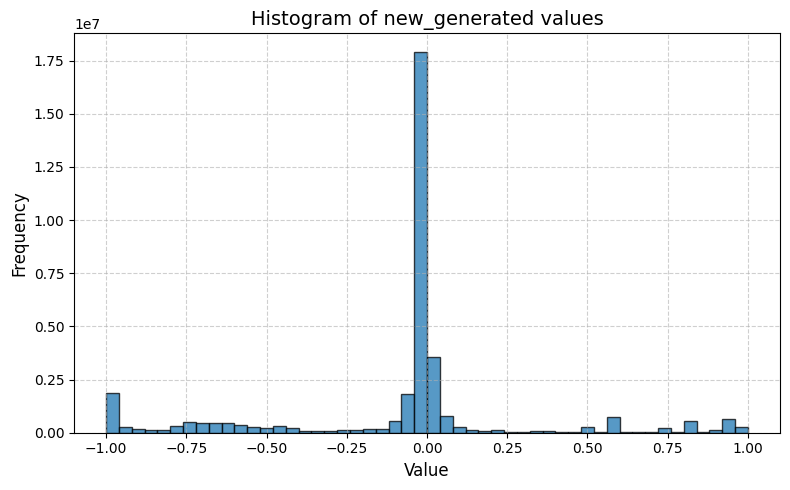


🎉 分布统计 + 直方图绘制完成


In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

PKL = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk"

print(f"📦 加载: {PKL}")
with open(PKL, "rb") as f:
    new_generated, obsmask, patient_ids = pickle.load(f)

new_generated = np.asarray(new_generated)  # (N,48,30)
vals = new_generated.reshape(-1)

N_total = vals.size

# =========================================================
# 统计 EXACT -1 和 +1 的比例
# =========================================================
n_min = np.sum(vals == -1.0)
n_max = np.sum(vals == 1.0)

print("\n📊 new_generated 数值范围统计:")
print("  全部数量 =", N_total)
print("  值 == -1.0 的数量 =", n_min, f"({n_min/N_total:.4%})")
print("  值 ==  1.0 的数量 =", n_max, f"({n_max/N_total:.4%})")

# =========================================================
# 检查是否存在接近饱和的值
# =========================================================
close_min = np.sum(vals < -0.95)
close_max = np.sum(vals > 0.95)

print("\n📌 接近饱和的值（<-0.95 或 >0.95）:")
print("  值 < -0.95 的数量 =", close_min, f"({close_min/N_total:.4%})")
print("  值 >  0.95 的数量 =", close_max, f"({close_max/N_total:.4%})")

# =========================================================
# 打印直方图数据
# =========================================================
hist, bin_edges = np.histogram(vals, bins=20, range=(-1,1))
print("\n📊 直方图分布 (20 bins):")
for b, h in zip(bin_edges[:-1], hist):
    print(f"  {b: .2f} ~ {b+0.1: .2f}: {h}")

# =========================================================
# ⭐ 画图：直方图 ⭐
# =========================================================
plt.figure(figsize=(8,5))
plt.hist(vals, bins=50, alpha=0.75, edgecolor='black')
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of new_generated values", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 显示图形
plt.show()

print("\n🎉 分布统计 + 直方图绘制完成")



In [15]:
import pickle
import numpy as np

PKL = "/playpen-shared/kechengli/workspace/Fusemoe/CSDI-main/save/ihm_fold_train10_20251119_004830/forFuse_train01.pk"

with open(PKL, "rb") as f:
    new_generated, obsmask, patient_ids = pickle.load(f)

new_generated = np.asarray(new_generated)
vals = new_generated.reshape(-1)

# 统计 0
num_zero = np.sum(vals == 0)
total = vals.size

for v in [-1.0, 0.0, 1.0]:
    count = np.sum(vals == v)
    print(f"值 == {v} 的数量: {count} ({count/total:.4%})")



值 == -1.0 的数量: 1730638 (4.8875%)
值 == 0.0 的数量: 1362 (0.0038%)
值 == 1.0 的数量: 224823 (0.6349%)
